# The main goal of this project is to create an application that, given a set of RGB colors, plots an intensity map of the image. For this, some similarity measures will be used to calculate the distance between the image pixels and the data point.

### Libraries 

In [105]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.covariance import LedoitWolf
from math import sqrt
import itertools

### First, we use a color picker to select the data frame to be used. Select the pixels by pressing left mouse button and moving it through the image. The "Q" key exits the window brosed.

[[253, 207, 116], [253, 207, 116], [255, 202, 102], [254, 202, 101], [255, 198, 109], [254, 198, 103], [253, 199, 102], [255, 193, 94], [255, 193, 94], [254, 189, 89], [255, 193, 104], [252, 195, 107], [255, 191, 108], [254, 174, 69], [255, 174, 74], [251, 186, 91], [251, 186, 91], [253, 192, 106], [255, 182, 84], [253, 180, 84], [253, 175, 78], [255, 180, 90], [255, 193, 109], [255, 193, 109], [254, 189, 94], [250, 172, 71], [247, 162, 59], [249, 162, 59], [242, 162, 65], [253, 175, 78], [253, 175, 78], [243, 152, 46], [248, 171, 75], [253, 185, 92], [255, 205, 136], [252, 199, 118], [253, 205, 128], [253, 213, 161], [249, 202, 144], [249, 202, 144], [245, 215, 189], [244, 219, 196], [239, 214, 191], [234, 207, 179], [223, 199, 174], [217, 198, 173], [217, 203, 187], [216, 209, 192], [216, 209, 192], [219, 208, 189], [213, 202, 182], [211, 204, 186], [211, 204, 186], [213, 206, 188], [208, 202, 181], [212, 206, 190], [208, 201, 183], [205, 197, 178], [206, 203, 177], [207, 205, 181], 

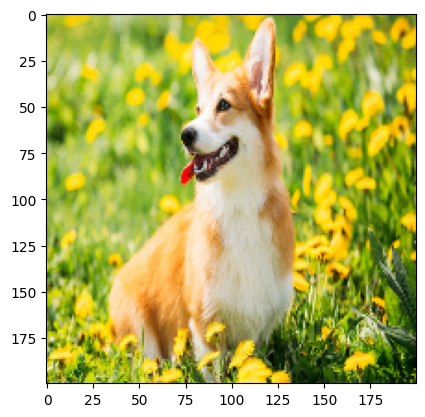

In [111]:
image = cv.imread('./corgi.jpg')
image = cv.resize(image, (200,200), cv.INTER_AREA)
# Resize the image for color picker
if image.shape[1] > 800:
    ratio = 800/image.shape[1]
    image = cv.resize(image, (int(image.shape[1]*ratio), int(image.shape[0]*ratio)), cv.INTER_AREA)
# If image still larger in the y ax
if image.shape[0] > 800:
    ratio =600/image.shape[1]
    image = cv.resize(image, (int(image.shape[1]*ratio), int(image.shape[0]*ratio)), cv.INTER_AREA)
cp_image = np.copy(image)

cv.imshow("Imagem", cp_image)
# Wait for the mouse event
colors_selected = []
def get_pixels(event, x, y, flags, param):
    global colors_selected
    if event == cv.EVENT_LBUTTONDOWN:
        colors_selected = []
    if event == cv.EVENT_MOUSEMOVE and flags == cv.EVENT_FLAG_LBUTTON:
        color = image[y, x]
        colors_selected.append([color[2],color[1],color[0]]) # channels inversed because of BGR
        cv.circle(cp_image, (x, y), 5, (255,255,255), -1)

cv.namedWindow("Image")
cv.setMouseCallback("Image", get_pixels)
# Show image with drawning
while True:
    cv.imshow("Image", cp_image)
    key = cv.waitKey(1)
    if key == ord('q'):
        break
cv.destroyAllWindows()

# Convert BGR to RGB for measures
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
print(colors_selected)

### Similarity distance and intensity map functions

In [107]:

# --------------- Euclidean functions ---------------
def euclidean_measure(x, y):
    return sqrt(pow(x[0]-y[0],2) + pow(x[1]-y[1],2) + pow(x[2]-y[2],2))

def intensity_map_euclidean(df, img):
    img_mean = np.mean(df, axis=0)
    intensity_map = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            distance = int(euclidean_measure((img[y][x][0], img[y][x][1], img[y][x][2]), img_mean))
            gray_value = 255 - int(255*distance/442) # 442 is the max distance
            intensity_map[y][x] = gray_value

    return intensity_map

# --------------- Mahalanobis functions ---------------
def mahalanobis_measure(df, point, inv_cov):
    # Center point
    centerpoint = np.mean(df , axis=0)
    distance = (point-centerpoint).T.dot(inv_cov).dot(point-centerpoint)
    if(distance < 0):
        distance = 0
    return np.sqrt(distance)

def max_min_mahalanobis_distances(df, inv_cov):
    # Returns approximately the min and max mahalanobis distances between the rgb spectre colors
    # and data frame
    
    r_values = range(0,256,10)
    g_values = range(0,256,10)
    b_values = range(0,256,10)
    rgb_combinations = np.array(list(itertools.product(r_values, g_values, b_values)))
    max_distance = 0
    min_distance = 0
    
    for i, rgb_color in enumerate(rgb_combinations):
        distance = mahalanobis_measure(df, rgb_color, inv_cov)
        if distance > max_distance:
            max_distance = distance
        if distance < min_distance or i == 0:
            min_distance = distance
    return min_distance, max_distance

def intensity_map_mahalanobis(df, img):
    # Como algumas matrizes de covariância não são inversíveis, usa-se o 
    # método de encolhimento de Ledoit-Wolf para criar uma matriz mais robusta
    lw = LedoitWolf(assume_centered=False)
    lw.fit(df)
    covariance = lw.covariance_
    inv_cov = np.linalg.matrix_power(covariance, -1)
    # Find max e min distances between df distribution and all rgb spectre
    min_d, max_d = max_min_mahalanobis_distances(df, inv_cov)
    intensity_map = np.zeros((img.shape[0], img.shape[1]), np.uint8)

    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            distance = mahalanobis_measure(df, img[x][y], inv_cov)
            intensity_map[x][y] = int((1-(distance / max_d)) * 255)
    
    return intensity_map

### Apply the similarity measure for every pixel

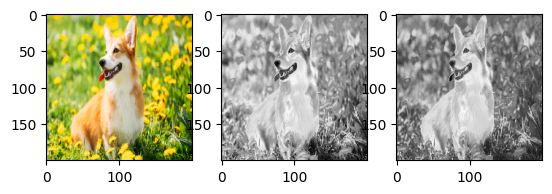

In [112]:
euclidean = intensity_map_euclidean(colors_selected, image)
mahalanobis = intensity_map_mahalanobis(colors_selected, image)
th, axes = plt.subplots(1,3)
axes[0].imshow(image)
axes[1].imshow(euclidean, 'gray')
axes[2].imshow(mahalanobis, 'gray')